# Proyek Klasifikasi Gambar: ***BRAIN TUMOR CLASSIFICATION***

## Import Semua Packages/Library yang Digunakan

In [1]:
# === SETUP & IMPORT ===
!pip -q install pipreqs tensorflowjs kaggle imutils

import os, shutil, random, zipfile, math, glob, datetime, cv2, warnings, sys, json, time, pathlib, itertools, imutils, sklearn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
from PIL import Image

from collections import Counter
from pathlib import Path
from google.colab import files as gfiles, drive

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from IPython.display import HTML, display, IFrame

warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.9.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Data Preparation

### Data Loading

In [2]:
# === UPLOAD KAGGLE API ===
# Upload kaggle.json (file kaggle.json dari local komputer)
uploaded = gfiles.upload()

# Pindahkan kaggle.json ke direktori ~/.kaggle dan set permission
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
for filename in uploaded:
    shutil.move(filename, os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

Saving kaggle.json to kaggle.json


In [3]:
# === DOWNLOAD DATASET DARI KAGGLE ===
!kaggle datasets download -d pradeep2665/brain-mri -p /content/

# === UNZIP ===
!unzip -q /content/brain-mri.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/pradeep2665/brain-mri
License(s): CC-BY-NC-SA-4.0
 98% 298M/303M [00:00<00:00, 361MB/s]
100% 303M/303M [00:01<00:00, 315MB/s]


In [4]:
# === Normalisasi Nama dan Struktur Folder ===
download_dir = "/content"

for folder_name in os.listdir(download_dir):
    full_path = os.path.join(download_dir, folder_name)
    if os.path.isdir(full_path) and " " in folder_name:
        new_name = folder_name.replace(" ", "_")
        new_path = os.path.join(download_dir, new_name)
        os.rename(full_path, new_path)
        print(f"📂 Rename: '{folder_name}' → '{new_name}'")

📂 Rename: 'MRI Dataset' → 'MRI_Dataset'


In [5]:
# === DETEKSI BASE DATASET & NAMA SPLIT OTOMATIS ===
def find_dataset_base(root="/content"):
    cands = []
    for d in os.listdir(root):
        p = os.path.join(root, d)
        if os.path.isdir(p):
            dl = d.lower()
            if ("mri" in dl) or ("brain" in dl and "dataset" in dl) or ("mri_dataset" in dl):
                cands.append(p)
    if not cands:
        raise FileNotFoundError("Base dataset tidak ditemukan di /content. Cek hasil unzip.")
    # pilih yang punya subfolder mirip train/val/test
    for p in cands:
        names = [n.lower() for n in os.listdir(p)]
        if any(n in names for n in ["train","training"]) and \
           any(n in names for n in ["val","valid","validation"]) and \
           any(n in names for n in ["test","testing"]):
            return p
    return cands[0]

def resolve_split_name(base, want):
    aliases = {"train": ["train","training"],
               "val":   ["val","valid","validation"],
               "test":  ["test","testing"]}
    names = os.listdir(base)
    for n in names:
        if n.lower() in aliases[want]:
            return n
    raise FileNotFoundError(f"Split '{want}' tidak ditemukan di {base}")

RAW_BASE = find_dataset_base()
SPLIT_MAP = {k: resolve_split_name(RAW_BASE, k) for k in ["train","val","test"]}
print("RAW_BASE:", RAW_BASE)
print("SPLIT_MAP:", SPLIT_MAP)

RAW_BASE: /content/MRI_Dataset
SPLIT_MAP: {'train': 'train', 'val': 'val', 'test': 'test'}


In [6]:
# === Cek Struktur ===
!find /content/MRI_Dataset -maxdepth 2 -type d -print

/content/MRI_Dataset
/content/MRI_Dataset/val
/content/MRI_Dataset/val/pituitary_tumor
/content/MRI_Dataset/val/no_tumor
/content/MRI_Dataset/val/meningioma_tumor
/content/MRI_Dataset/val/glioma_tumor
/content/MRI_Dataset/train
/content/MRI_Dataset/train/pituitary_tumor
/content/MRI_Dataset/train/no_tumor
/content/MRI_Dataset/train/meningioma_tumor
/content/MRI_Dataset/train/glioma_tumor
/content/MRI_Dataset/test
/content/MRI_Dataset/test/pituitary_tumor
/content/MRI_Dataset/test/no_tumor
/content/MRI_Dataset/test/meningioma_tumor
/content/MRI_Dataset/test/glioma_tumor


In [7]:
# === MANUAL STRATIFIED SPLIT (gabung semua split bawaan → split ulang sendiri) ===
random.seed(42)

ALL_BASE = "/content/MRI_All"                    # gabungan semua gambar per kelas
SPLIT_BASE = "/content/MRI_Split_Manual"         # hasil split mandiri: train/val/test

# 1) Gabungkan semua gambar ke satu folder per kelas
shutil.rmtree(ALL_BASE, ignore_errors=True)
os.makedirs(ALL_BASE, exist_ok=True)

for split in ["train", "val", "test"]:
    split_name = SPLIT_MAP[split]
    split_dir = os.path.join(RAW_BASE, split_name)
    for cls in sorted(os.listdir(split_dir)):
        src = os.path.join(split_dir, cls)
        if not os.path.isdir(src):
            continue
        dst = os.path.join(ALL_BASE, cls)
        os.makedirs(dst, exist_ok=True)
        for fp in glob.glob(os.path.join(src, "*")):
            if Path(fp).suffix.lower() in (".png",".jpg",".jpeg",".bmp",".tif",".tiff"):
                shutil.copy2(fp, os.path.join(dst, f"{split}__{Path(fp).name}"))

print("✅ Semua data digabung per kelas ke:", ALL_BASE)

# 2) Stratified per-kelas: 80% train, 10% val, 10% test
train_ratio, val_ratio, test_ratio = 0.80, 0.10, 0.10
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

shutil.rmtree(SPLIT_BASE, ignore_errors=True)
for sub in ["train", "val", "test"]:
    os.makedirs(os.path.join(SPLIT_BASE, sub), exist_ok=True)

total_files = 0
for cls in sorted(os.listdir(ALL_BASE)):
    cls_dir = os.path.join(ALL_BASE, cls)
    if not os.path.isdir(cls_dir):
        continue
    files_cls = sorted(str(p) for p in Path(cls_dir).glob("*")
                       if p.suffix.lower() in (".png",".jpg",".jpeg",".bmp",".tif",".tiff"))
    total_files += len(files_cls)

    # train vs temp (val+test)
    train_files, temp_files = train_test_split(
        files_cls, test_size=(1-train_ratio), random_state=42, shuffle=True, stratify=None
    )
    rel = val_ratio / (val_ratio + test_ratio)
    val_files, test_files = train_test_split(
        temp_files, test_size=(1-rel), random_state=42, shuffle=True, stratify=None
    )

    for dst_sub, lst in [("train", train_files), ("val", val_files), ("test", test_files)]:
        out_dir = os.path.join(SPLIT_BASE, dst_sub, cls)
        os.makedirs(out_dir, exist_ok=True)
        for fp in lst:
            shutil.copy2(fp, os.path.join(out_dir, Path(fp).name))

print("✅ Split mandiri selesai di:", SPLIT_BASE, "| Total file:", total_files)

✅ Semua data digabung per kelas ke: /content/MRI_All
✅ Split mandiri selesai di: /content/MRI_Split_Manual | Total file: 10000


### Data Preprocessing

#### Custom Preprocessing: Crop + Padding

Pada proyek ini **tidak digunakan `tf.image.resize_with_pad` bawaan TensorFlow**, melainkan preprocessing kustom berupa **crop + padding**.  

**Alasan pemilihan metode ini:**

1. **Fokus pada objek utama (otak/tumor).**  
   - Dengan mendeteksi kontur terbesar, citra dipotong sehingga bagian kosong (background hitam) dibuang.  
   - Hasilnya, model hanya menerima informasi yang relevan.

2. **Konsistensi ukuran dengan padding.**  
   - Setelah cropping, citra di-*resize* sesuai rasio asli, lalu ditambahkan padding hitam agar tetap persegi.  
   - Padding hanya berfungsi menjaga ukuran input (224×224), bukan menambah informasi palsu.

3. **Efisiensi dan akurasi.**  
   - Model tidak “terganggu” oleh noise area hitam yang besar.  
   - CNN lebih fokus pada pola di dalam otak, sehingga hasil klasifikasi lebih akurat.

**Catatan:**  
Metode bawaan `resize_with_pad` memang praktis, tetapi tidak membedakan mana area otak dan mana background. Semua sisi (atas, bawah, kiri, kanan) akan dipadding secara seragam, sehingga bisa menambah area kosong yang tidak informatif.  

Karena itu, preprocessing kustom ini saya terapkan agar model CNN yang sederhana ini dapat fokus pada data citra medis seperti MRI.

#### Crop Image

In [8]:
# === FUNGI PREPROCESSING ===
def preprocess_mri_image(img, label=None, img_size=224, min_crop_area_ratio=0.1, add_margin=12):
    def crop_img(img):
        """
        Crop berbasis kontur dengan otsu threshold + validasi area
        """
        # Step 1: Grayscale dan blur ringan
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)


        # Step 2: Otsu threshold
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Step 3: Morphological noise removal
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Step 4: Ambil kontur
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if len(cnts) == 0:
            return img  # fallback: return original

        # Step 5: Ambil kontur terbesar
        c = max(cnts, key=cv2.contourArea)
        area = cv2.contourArea(c)
        img_area = img.shape[0] * img.shape[1]

        if area < img_area * 0.1:
            return img  # ignore jika crop terlalu kecil

        # Step 6: Ambil extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Step 7: Crop gambar
        cropped = img[
            max(extTop[1] - 12, 0):min(extBot[1] + 12, img.shape[0]),
            max(extLeft[0] - 12, 0):min(extRight[0] + 12, img.shape[1])
        ].copy()

        return cropped

    def resize_with_padding(image, desired_size):
        """
        Resize image tanpa merusak aspek rasio,
        kemudian menambahkan padding (hitam) agar pas persegi.
        """
        old_h, old_w = image.shape[:2]
        ratio = float(desired_size) / max(old_h, old_w)
        new_w, new_h = int(old_w * ratio), int(old_h * ratio)

        resized = cv2.resize(image, (new_w, new_h))
        delta_w = desired_size - new_w
        delta_h = desired_size - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                     cv2.BORDER_CONSTANT, value=color)
        return new_img

    # === PREPROCESSING LOGIC ===
    if label == 'no_tumor':
        cropped = img
    else:
        cropped = crop_img(img)

    final_img = resize_with_padding(cropped, desired_size=img_size)
    return final_img

In [9]:
# === SETUP PATHS ===
raw_base_dir = SPLIT_BASE  # direktori awal dataset
train_dir_raw = os.path.join(raw_base_dir, "train")
val_dir_raw   = os.path.join(raw_base_dir, "val")
test_dir_raw  = os.path.join(raw_base_dir, "test")

clean_base_dir = "/content/MRI_Split_Manual_Cleaned"
train_dir_clean = os.path.join(clean_base_dir, "train")
val_dir_clean   = os.path.join(clean_base_dir, "val")
test_dir_clean  = os.path.join(clean_base_dir, "test")

IMG_SIZE = 224
os.makedirs(clean_base_dir, exist_ok=True)

# === CROPPING SEMUA DATASET ===
for src, dst in [(train_dir_raw, train_dir_clean),
                 (val_dir_raw, val_dir_clean),
                 (test_dir_raw, test_dir_clean)]:
    for cls in os.listdir(src):
        src_cls = os.path.join(src, cls)
        dst_cls = os.path.join(dst, cls)
        os.makedirs(dst_cls, exist_ok=True)

        for fname in tqdm(os.listdir(src_cls), desc=f"Cropping {cls}"):
            img_path = os.path.join(src_cls, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            clean_img = preprocess_mri_image(img, label=cls, img_size=IMG_SIZE)
            cv2.imwrite(os.path.join(dst_cls, fname), clean_img)

print(f"\n✅ Semua dataset berhasil diproses dengan cropping + padding yang robust.")

Cropping glioma_tumor: 100%|██████████| 250/250 [00:00<00:00, 324.01it/s]


✅ Semua dataset berhasil diproses dengan cropping + padding yang robust.


In [10]:
# === SET PATH & SANITY CHECK (HASIL CROP) ===
base_dir = clean_base_dir
train_dir = train_dir_clean
val_dir   = val_dir_clean
test_dir  = test_dir_clean

for d in [train_dir, val_dir, test_dir]:
    print(d, "->", os.listdir(d))

/content/MRI_Split_Manual_Cleaned/train -> ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
/content/MRI_Split_Manual_Cleaned/val -> ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
/content/MRI_Split_Manual_Cleaned/test -> ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']


#### Visualisasi Hasil Crop dan Distribusi Image Tiap Kelas

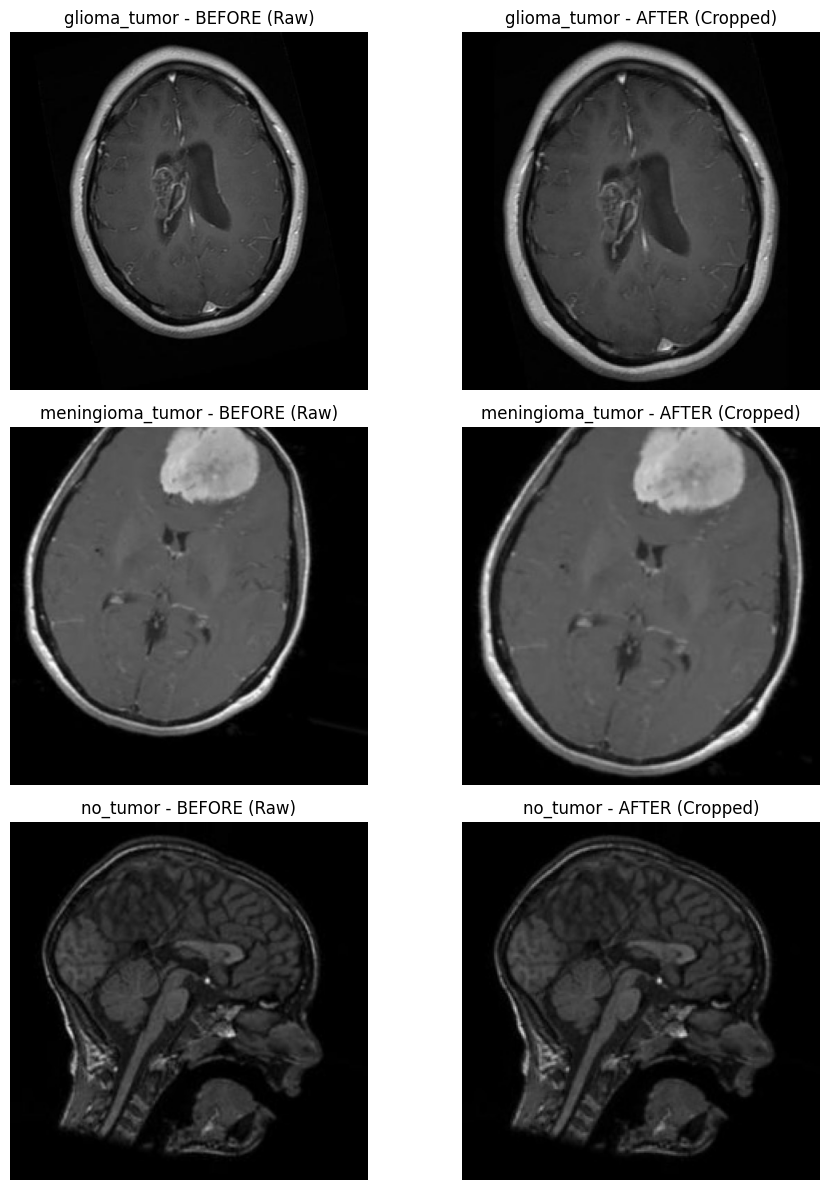

In [11]:
# === CEK HASIL CROPPING SECARA VISUAL (BEFORE vs AFTER) ===
n_samples = 3
plt.figure(figsize=(10, n_samples * 4))

for i, cls in enumerate(sorted(os.listdir(train_dir_clean))[:n_samples]):
    cls_path_clean = os.path.join(train_dir_clean, cls)
    cls_path_raw = os.path.join(train_dir_raw, cls)
    sample_file = random.choice(os.listdir(cls_path_clean))

    img_clean_path = os.path.join(cls_path_clean, sample_file)
    img_raw_path = os.path.join(cls_path_raw, sample_file)

    # baca gambar
    img_clean = mpimg.imread(img_clean_path)
    img_raw = mpimg.imread(img_raw_path)

    # subplot before-after
    plt.subplot(n_samples, 2, i*2 + 1)
    plt.imshow(img_raw)
    plt.title(f"{cls} - BEFORE (Raw)")
    plt.axis("off")

    plt.subplot(n_samples, 2, i*2 + 2)
    plt.imshow(img_clean)
    plt.title(f"{cls} - AFTER (Cropped)")
    plt.axis("off")

plt.tight_layout()
plt.show()

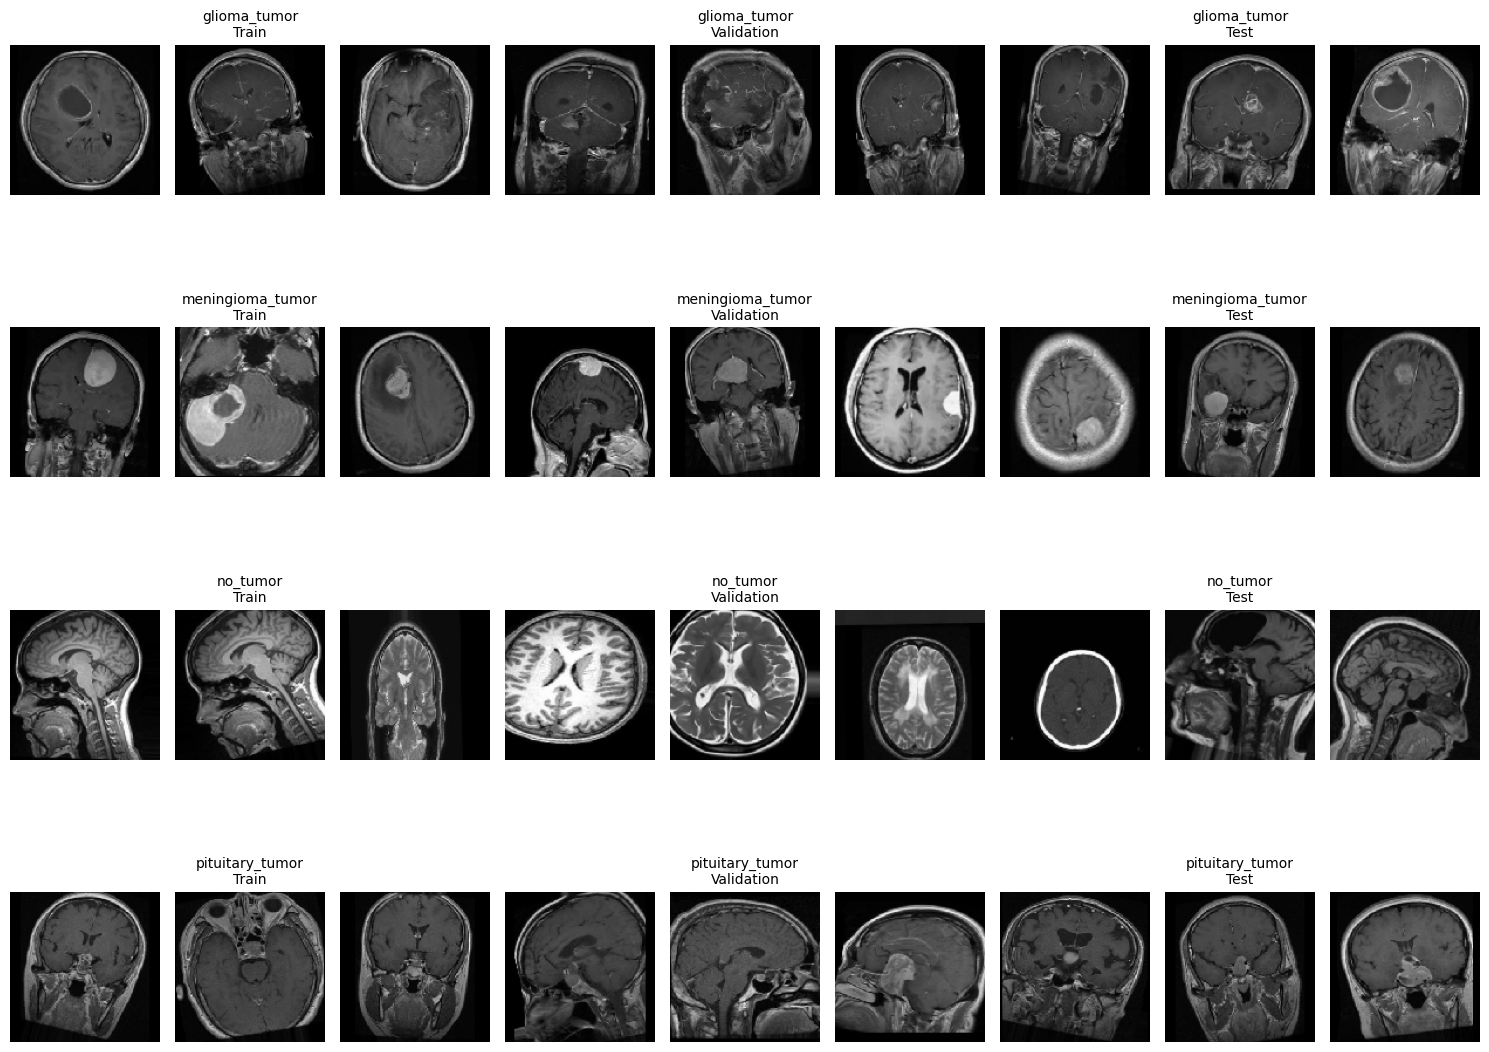

In [12]:
# === SHOWING IMG ===
splits = {"Train": train_dir, "Validation": val_dir, "Test": test_dir}

# ambil daftar kelas dari folder Train
class_names = sorted(os.listdir(train_dir))

# plotting
plt.figure(figsize=(15, len(class_names)*3))  # tinggi menyesuaikan jumlah kelas

for row_idx, label in enumerate(class_names):
    for col_idx, (split_name, split_path) in enumerate(splits.items()):
        folder = os.path.join(split_path, label)
        files = os.listdir(folder)
        k = min(3, len(files))
        sample_files = random.sample(files, k) if k > 0 else []

        for i, fname in enumerate(sample_files):
            img_path = os.path.join(folder, fname)
            img = load_img(img_path, target_size=(128, 128))
            plt.subplot(len(class_names), 9, row_idx*9 + col_idx*3 + i + 1)
            plt.imshow(img)
            plt.axis("off")
            if i == 1:  # kasih judul di gambar tengah tiap split
                plt.title(f"{label}\n{split_name}", fontsize=10)

plt.tight_layout()
plt.show()

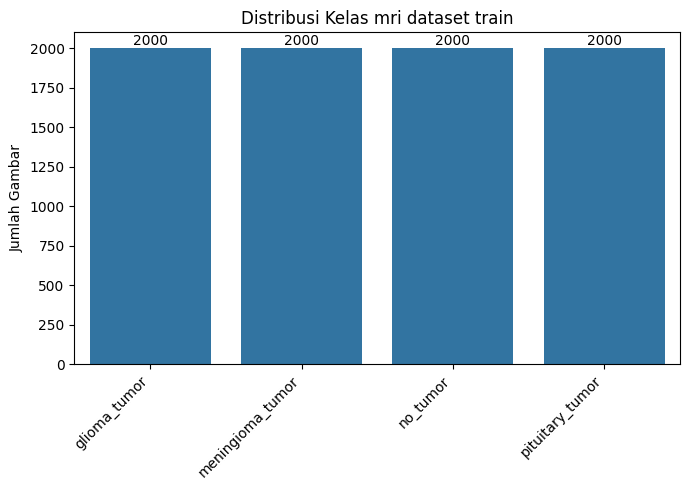

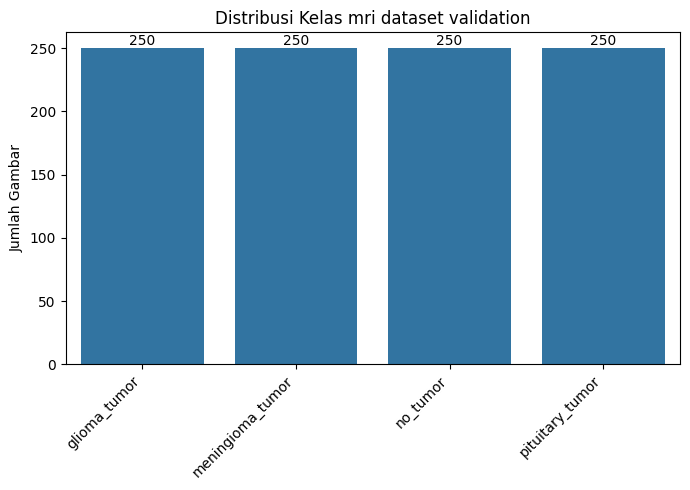

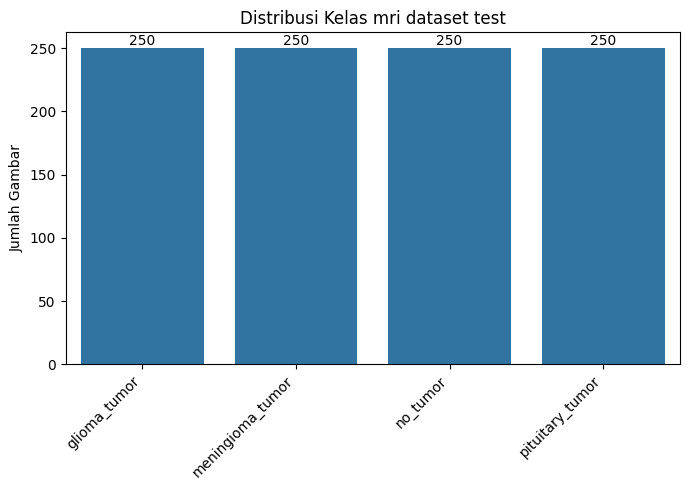


Train: {'glioma_tumor': 2000, 'meningioma_tumor': 2000, 'no_tumor': 2000, 'pituitary_tumor': 2000}

Val  : {'glioma_tumor': 250, 'meningioma_tumor': 250, 'no_tumor': 250, 'pituitary_tumor': 250}

Test : {'glioma_tumor': 250, 'meningioma_tumor': 250, 'no_tumor': 250, 'pituitary_tumor': 250}

Total per split:
Train = 8000
Val = 1000
Test = 1000

Total Keseluruhan = 10000


In [13]:
# === DISTRIBUSI KELAS (TRAIN/VAL/TEST) ===
def count_per_class(folder):
    cls_counts = {}
    for cls in sorted([c for c in os.listdir(folder) if os.path.isdir(os.path.join(folder, c))]):
        cls_counts[cls] = len(os.listdir(os.path.join(folder, cls)))
    return cls_counts

def plot_counts(title, counts):
    plt.figure(figsize=(7,5))
    ax = sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(title); plt.ylabel("Jumlah Gambar"); plt.xticks(rotation=45, ha='right')
    for p in ax.patches:
        ax.annotate(f"{int(p.get_height())}",
                    (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)
    plt.tight_layout(); plt.show()

train_counts = count_per_class(train_dir)
val_counts   = count_per_class(val_dir)
test_counts  = count_per_class(test_dir)

plot_counts("Distribusi Kelas mri dataset train", train_counts)
plot_counts("Distribusi Kelas mri dataset validation", val_counts)
plot_counts("Distribusi Kelas mri dataset test", test_counts)

sum_train = sum(train_counts.values())
sum_val   = sum(val_counts.values())
sum_test  = sum(test_counts.values())
sum_total = sum_train + sum_val + sum_test

print(f"\nTrain:", train_counts)
print(f"\nVal  :", val_counts)
print(f"\nTest :", test_counts)
print(f"\nTotal per split:")
print(f"Train = {sum_train}")
print(f"Val = {sum_val}")
print(f"Test = {sum_test}")
print(f"\nTotal Keseluruhan = {sum_total}")

#### ImageDataGenerator & Augmentation Setup

In [14]:
# === DATA GENERATOR ===

train_datagen = ImageDataGenerator(                  # Augmentasi pada Train
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.12,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1],
    shear_range=0.05
)

val_test_datagen = ImageDataGenerator(rescale=1./255) # Val dan Test tanpa augmentasi

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"\nClass indices:", train_generator.class_indices)

Found 8000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.

Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


## Modelling

### CNN Modeling

#### Utility

In [15]:
# === TRAINING LOGGER ===

def get_current_lr(optimizer) -> float:
    """Robust ambil nilai learning rate dari optimizer (kompatibel TF/Keras versi umum)."""
    lr = optimizer.learning_rate
    try:
        # Jika variable/tensor
        return float(tf.keras.backend.get_value(lr))
    except Exception:
        # Jika python float/schedule
        try:
            return float(lr.numpy())
        except Exception:
            return float(lr)

class TrainingLogger(keras.callbacks.Callback):
    def __init__(self, min_delta=0.0, output_csv_path=None):
        super().__init__()
        self.min_delta = float(min_delta)
        self.output_csv_path = output_csv_path
        self.records = []
        self.best_val = math.inf
        self.best_epoch = -1
        self.prev_lr = None

    def on_train_begin(self, logs=None):
        self.prev_lr = get_current_lr(self.model.optimizer)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Metrik yang umum tersedia
        tr_loss = float(logs.get("loss", np.nan))
        tr_acc  = float(logs.get("accuracy", np.nan))
        va_loss = float(logs.get("val_loss", np.nan))
        va_acc  = float(logs.get("val_accuracy", np.nan))

        # Cek improvement val_loss
        improved = False
        if not np.isnan(va_loss):
            if (self.best_val - va_loss) > self.min_delta:
                self.best_val = va_loss
                self.best_epoch = epoch
                improved = True

        # Cek LR turun
        lr_now = get_current_lr(self.model.optimizer)
        lr_drop = (lr_now < self.prev_lr - 1e-12)
        self.prev_lr = lr_now

        note = []
        if improved:
            note.append("val_loss improved")
        else:
            note.append("val_loss not improved")
        if lr_drop:
            note.append("LR↓")

        self.records.append({
            "epoch": epoch + 1,  # tampilkan 1-based biar enak dibaca
            "train_loss": tr_loss,
            "val_loss": va_loss,
            "train_acc": tr_acc,
            "val_acc": va_acc,
            "lr": lr_now,
            "note": ", ".join(note)
        })

    # Utilitas setelah training untuk output DataFrame + CSV
    def to_dataframe(self):
        return pd.DataFrame(self.records)

    def save_csv(self):
        if self.output_csv_path:
            df = self.to_dataframe()
            df.to_csv(self.output_csv_path, index=False)
            print(f"📄 Training report saved to: {self.output_csv_path}")

    def summary_text(self):
        if not self.records:
            return "No records."
        last_epoch = self.records[-1]["epoch"]
        best_line = f"Best val_loss at epoch {self.best_epoch+1} = {self.best_val:.6f}" if self.best_epoch >= 0 else "No val_loss recorded."
        return (
            f"Training finished at epoch {last_epoch}.\n"
            + best_line
        )

In [16]:
# === HTML REPORT ===

def render_training_report_html(
    df_report: pd.DataFrame,
    best_epoch: int,
    best_val_loss: float,
    outfile: str = "training_report.html",
    title: str = "CNN Training Report (Classification)",
    show_iframe: bool = False,
    iframe_height: int = 480,
):
    """
    df_report: DataFrame berkolom ['epoch','train_loss','val_loss','train_acc','val_acc','lr','note']
               (berasal dari TrainingReporter yang dipakai).
    best_epoch: index epoch terbaik (0-based) -> akan ditampilkan 1-based.
    best_val_loss: nilai val_loss terbaik.
    outfile: path file HTML untuk disimpan.
    show_iframe: True => render via iframe di notebook. False => render via file HTML
    """

    # --- safety copy & format angka
    df = df_report.copy()
    for col in ["train_loss", "val_loss", "train_acc", "val_acc", "lr"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").round(6)

    # kolom badge emoji (opsional)
    def _badge(note):
        badges = []
        if isinstance(note, str) and "val_loss improved" in note:
            badges.append("✅")
        if isinstance(note, str) and "LR↓" in note:
            badges.append("📉")
        return " ".join(badges)
    if "note" in df.columns and "badge" not in df.columns:
        df["badge"] = df["note"].apply(_badge)

    css = """
    <style>
      /* ——— RESET DARK MODE ——— */
      .report-root, .report-root * { color: #111 !important; }
      .report-root { background: #f6f7fb !important; }

      /* ——— CONTAINER ——— */
      .report-card {
        background: #ffffff !important;
        border: 1px solid #e7e9f0 !important;
        border-radius: 14px;
        padding: 18px 18px 14px;
        margin: 10px 0;
        box-shadow:
          0 1px 2px rgba(16, 24, 40, .06),
          0 8px 24px rgba(16, 24, 40, .06);
      }

      .report-title {
        margin: 0 0 6px 0;
        font-size: 22px;
        font-weight: 800;
        letter-spacing: .2px;
      }

      .report-meta {
        margin: 0 0 14px 0;
        font-size: 12.5px;
        color: #475467 !important;
      }

      /* ——— TABLE WRAP ——— */
      .table-wrap {
        max-height: 420px;
        overflow: auto;
        border-radius: 12px;
        border: 1px solid #e7e9f0 !important;
        background: #fff !important;
      }

      /* ——— TABLE ——— */
      table.report {
        width: 100%;
        border-collapse: separate;
        border-spacing: 0;
        font-size: 13px;
        background: #fff !important;
      }
      thead th {
        position: sticky; top: 0; z-index: 2;
        background: linear-gradient(180deg,#f9fafb 0%, #f2f4f7 100%) !important;
        color: #111 !important;
        text-align: left;
        padding: 10px 10px;
        border-bottom: 1px solid #e7e9f0 !important;
        font-weight: 700;
      }
      tbody td {
        padding: 9px 10px;
        border-bottom: 1px solid #f1f2f6 !important;
        background: #fff !important;
      }

      /* Zebra + hover */
      tbody tr:nth-child(odd) td { background: #fcfcfd !important; }
      tbody tr:hover td { background: #f5faff !important; }

      /* ——— ROW HIGHLIGHTS ——— */
      .row-improved td  { background: #ecfdf3 !important; }   /* green */
      .row-lrdown  td   { background: #fff8e6 !important; }   /* amber */
      .row-both td      {
        background: #eafff3 !important;
        box-shadow: inset 0 1px 0 #fde68a, inset 0 -1px 0 #fde68a;
      }

      /* ——— BADGES ——— */
      .legend { font-size: 12px; color: #475467 !important; margin-top: 10px; }
      .pill {
        display: inline-flex; align-items: center; gap: 6px;
        padding: 3px 10px; border-radius: 999px;
        font-size: 12px; font-weight: 600;
        border: 1px solid #e5e7eb !important; background: #f8fafc !important; color: #111 !important;
        box-shadow: inset 0 -1px 0 rgba(16,24,40,0.04);
        margin-right: 8px;
      }
      .pill .dot {
        width: 8px; height: 8px; border-radius: 999px; display: inline-block;
        box-shadow: 0 0 0 1px rgba(16,24,40,0.04) inset;
      }
      .pill-green  .dot { background: #16a34a; }
      .pill-amber  .dot { background: #f59e0b; }
      .pill-best   { background: #e6ffed !important; border-color: #bbf7d0 !important; color: #065f46 !important; }

      .code {
        font-family: ui-monospace,SFMono-Regular,Menlo,Consolas,monospace;
        font-size: 12px; padding: 2px 6px; border-radius: 6px;
        border: 1px solid #e5e7eb !important; background: #f8fafc !important; color: #111 !important;
      }
    </style>
    """

    # Tabel HTML (tanpa index)
    cols = [c for c in ["epoch","train_loss","val_loss","train_acc","val_acc","lr","note","badge"] if c in df.columns]
    html_table = df[cols].to_html(classes="report", index=False, escape=False)

    js = """
    <script>
      (function(){
        const table = document.querySelector('table.report');
        if(!table) return;
        const rows = table.querySelectorAll('tbody tr');
        rows.forEach((tr) => {
          const noteCell = tr.children[6]; // kolom 'note'
          if(!noteCell) return;
          const note = (noteCell.textContent || "").toLowerCase();
          if (note.includes("val_loss improved") && note.includes("lr↓")) {
            tr.classList.add("row-both");
          } else if (note.includes("val_loss improved")) {
            tr.classList.add("row-improved");
          } else if (note.includes("lr↓")) {
            tr.classList.add("row-lrdown");
          }
        });
      })();
    </script>
    """

    created_at = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    best_line = (
        f"Best <span class='code'>val_loss</span> at epoch <b>{best_epoch+1}</b> = <b>{best_val_loss:.6f}</b>"
        if best_epoch >= 0 else "No validation loss recorded."
    )

    html = f"""
    {css}
    <div class="report-root">
      <div class="report-card">
        <div class="report-title">{title}</div>
        <div class="report-meta">
          Generated at: <span class="code">{created_at}</span> &middot; {best_line}
        </div>
        <div class="table-wrap">{html_table}</div>
        <div class="legend">
          <span class="pill pill-green"><span class="dot"></span> val_loss improved</span>
          <span class="pill pill-amber"><span class="dot"></span> LR decreased</span>
          <span class="pill pill-best">Best val_loss</span>
        </div>
      </div>
    </div>
    {js}
    """

    # Simpan & tampilkan
    with open(outfile, "w", encoding="utf-8") as f:
        f.write(html)
    print(f"📝 Saved HTML report to: {outfile}")

    if show_iframe:
        display(IFrame(outfile, width="100%", height=iframe_height))
    else:
        display(HTML(html))

#### 1. Modelling (Sequential + Conv2D + Pooling)

In [17]:
# === STRUKTUR MODELLING (CNN) ===
SEED = 42
tf.random.set_seed(SEED)

# jumlah kelas dari generator validasi (berisi 7 kelas lengkap)
num_classes = len(val_generator.class_indices)
input_shape = (224, 224, 3)

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

#### 2. Callbacks

In [18]:
# === CALLBACKS ===

# Training Logger
report_csv_path = "training_report.csv"
reporter = TrainingLogger(min_delta=0.0, output_csv_path=report_csv_path)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
        ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
        ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
        ),
    reporter # training logger disini
]

#### 3. Training Cell

In [19]:
# === TRAINING ===
EPOCHS = 60
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.5714 - loss: 1.0580
Epoch 1: val_loss improved from inf to 7.00685, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5720 - loss: 1.0568 - val_accuracy: 0.2500 - val_loss: 7.0068 - learning_rate: 0.0010
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.7369 - loss: 0.6638
Epoch 2: val_loss did not improve from 7.00685
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 900ms/step - accuracy: 0.7369 - loss: 0.6637 - val_accuracy: 0.2500 - val_loss: 7.5041 - learning_rate: 0.0010
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.7803 - loss: 0.5617
Epoch 3: val_loss improved from 7.00685 to 5.61524, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 897ms/step - accuracy: 0.7803 - loss: 0.5616 - val_accuracy: 0.2510 - val_loss: 5.6152 - learning_rate: 0.0010
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8260 - loss: 0.4807
Epo

#### 4. Training Report, Plot Akurasi, dan Loss


===== TRAINING SUMMARY =====
Training finished at epoch 53.
Best val_loss at epoch 45 = 0.035863




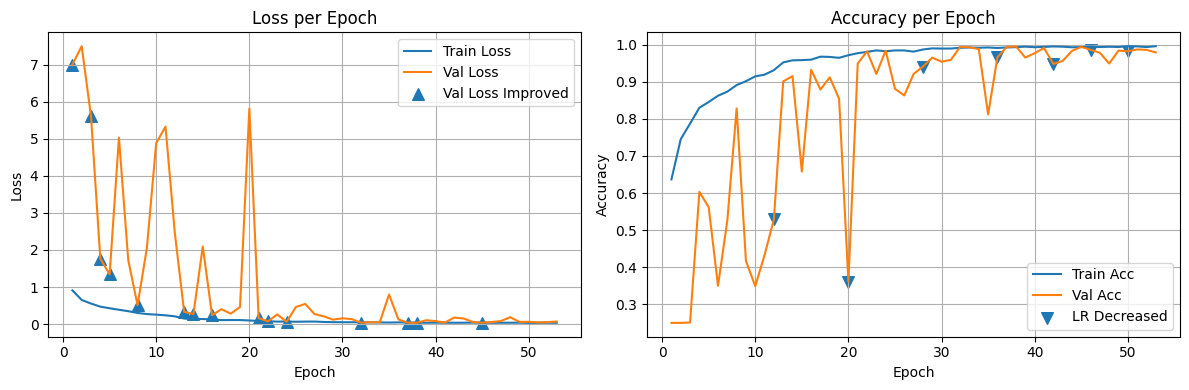

📝 Saved HTML report to: training_report.html


In [20]:
# === TRAINING REPORT ===
df_report = reporter.to_dataframe()

# Ringkasan teks
print("\n===== TRAINING SUMMARY =====")
print(reporter.summary_text())
print("\n")

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Loss
axes[0].plot(df_report["epoch"], df_report["train_loss"], label="Train Loss")
axes[0].plot(df_report["epoch"], df_report["val_loss"], label="Val Loss")

# Tandai improvement
improve_epochs = df_report[df_report["note"].str.contains("val_loss improved")]["epoch"].values
axes[0].scatter(improve_epochs, df_report.loc[df_report["epoch"].isin(improve_epochs), "val_loss"],
                marker="^", s=70, label="Val Loss Improved")

axes[0].set_title("Loss per Epoch")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss"); axes[0].legend(); axes[0].grid(True)

# Accuracy
axes[1].plot(df_report["epoch"], df_report["train_acc"], label="Train Acc")
axes[1].plot(df_report["epoch"], df_report["val_acc"], label="Val Acc")

# Tandai epoch saat LR turun
lr_down_epochs = df_report[df_report["note"].str.contains("LR↓")]["epoch"].values
axes[1].scatter(lr_down_epochs, df_report.loc[df_report["epoch"].isin(lr_down_epochs), "val_acc"],
                marker="v", s=70, label="LR Decreased")

axes[1].set_title("Accuracy per Epoch")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy"); axes[1].legend(); axes[1].grid(True)

plt.tight_layout(); plt.show()

# Render training history di notebook + simpan file HTML
render_training_report_html(
    df_report=df_report,
    best_epoch=reporter.best_epoch,
    best_val_loss=reporter.best_val,
    outfile="training_report.html",
    title="CNN Training Report (Classification)",
    show_iframe=False,
    iframe_height=480
)

# (Opsional) Download file HTML
# gfiles.download("training_report.html")


## Evaluasi dan Visualisasi

Train Loss: 0.0289 | Train Acc: 0.9971
Test  Loss: 0.0360 | Test  Acc:  0.9950
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    0.9960    0.9980       250
meningioma_tumor     0.9960    0.9920    0.9940       250
        no_tumor     1.0000    0.9960    0.9980       250
 pituitary_tumor     0.9842    0.9960    0.9901       250

        accuracy                         0.9950      1000
       macro avg     0.9950    0.9950    0.9950      1000
    weighted avg     0.9950    0.9950    0.9950      1000



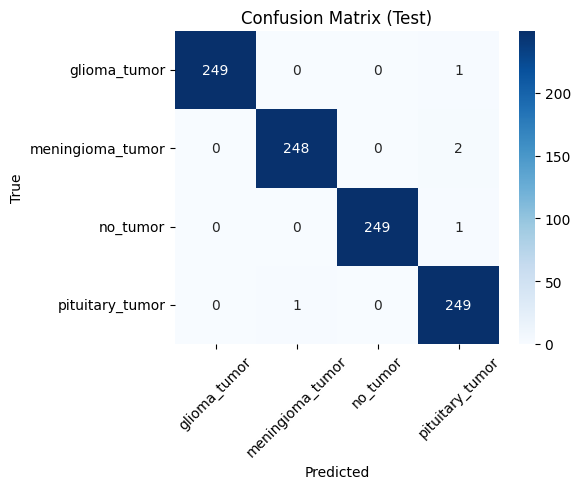

In [21]:
# === EVALUASI MENGGUNAKAN CHECKPOINT TERBAIK ===
best = tf.keras.models.load_model('best_model.keras')

train_loss, train_acc = best.evaluate(train_generator, verbose=0)
test_loss,  test_acc  = best.evaluate(test_generator,  verbose=0)
print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
print(f"Test  Loss: {test_loss:.4f} | Test  Acc:  {test_acc:.4f}")

# Syarat Dicoding (>= 85% untuk Training dan Testing)
assert train_acc >= 0.85, f"Training accuracy {train_acc:.3f} < 0.85 (syarat Dicoding)."
assert test_acc  >= 0.85, f"Test accuracy {test_acc:.3f} < 0.85 (syarat Dicoding)."

# Prediksi & laporan klasifikasi (TEST)
y_prob = best.predict(test_generator, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes
idx_to_class = {v:k for k,v in test_generator.class_indices.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Konversi Model

In [22]:
# === SIMPAN 3 FORMAT DARI MODEL TERBAIK ===
submission_dir = "submission"
saved_model_dir = os.path.join(submission_dir, "saved_model")
tfjs_dir = os.path.join(submission_dir, "tfjs_model")
tflite_dir = os.path.join(submission_dir, "tflite")

if os.path.exists(submission_dir):
    shutil.rmtree(submission_dir)
os.makedirs(saved_model_dir, exist_ok=True)
os.makedirs(tfjs_dir, exist_ok=True)
os.makedirs(tflite_dir, exist_ok=True)

print("💾 Menyimpan .keras (best)...")
best.save(os.path.join(submission_dir, "brain_mri_model.keras"))

print("📦 Mengekspor SavedModel (best)...")
best.export(saved_model_dir)

print("🔄 Konversi ke TFLite (best)...")
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(os.path.join(tflite_dir, "brain_mri_model.tflite"), "wb") as f:
    f.write(tflite_model)

print("🌐 Konversi ke TensorFlow.js (best)...")
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve {saved_model_dir} {tfjs_dir}

💾 Menyimpan .keras (best)...
📦 Mengekspor SavedModel (best)...
Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132632473936016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632473933136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632551805136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632551805520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632551806096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632551807056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632551805904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632551809168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632551805712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132632551807632:

In [23]:
# === LIST ARTEFAK & ZIP ===
!find submission -maxdepth 2 -type f -print | sort

zip_filename = "submission.zip"
shutil.make_archive("submission", 'zip', submission_dir)
print(f"\n📚 Arsip dibuat: {zip_filename}")

print("⬇️ Mengunduh submission.zip ...")
gfiles.download(zip_filename)

submission/brain_mri_model.keras
submission/saved_model/fingerprint.pb
submission/saved_model/saved_model.pb
submission/tfjs_model/group1-shard1of1.bin
submission/tfjs_model/model.json
submission/tflite/brain_mri_model.tflite

📚 Arsip dibuat: submission.zip
⬇️ Mengunduh submission.zip ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference Pipeline – Brain MRI Classification & Visualization Using Grad-Cam

Pada section ini, kita melakukan **inference end-to-end** terhadap model klasifikasi MRI otak.  
Pipeline inference dirancang modular dan sistematis agar bisa langsung digunakan baik untuk:
- Prediksi **single image**,
- Evaluasi pada **seluruh test set**,
- Visualisasi interpretabilitas dengan **Grad-CAM**, serta
- Perbandingan prediksi model dengan **ground truth segmentation mask**.

---

### Alur Pipeline Inference

1. **Configuration**  
   - Menentukan path model (`.keras` / SavedModel), direktori dataset test, dan output folder.  
   - Mendefinisikan parameter penting seperti ukuran input (`224x224`), jumlah channel (RGB), serta daftar nama kelas (`glioma`, `meningioma`, `no_tumor`, `pituitary`).

2. **Load Model**  
   - Fungsi `load_any_keras_model()` digunakan agar pipeline fleksibel membaca model dalam dua format: folder `SavedModel` atau file `.keras`.  
   - Model di-load dengan `compile=False` untuk inference-only (tanpa membawa optimizer/loss training).  

3. **Preprocessing**  
   - Fungsi `preprocess_batch()` menyiapkan citra sebelum inference:  
     - Membaca gambar (OpenCV → RGB).  
     - **Cropping** otomatis berdasarkan kontur otak terbesar agar background noise berkurang.  
     - **Resize dengan padding** → menjaga aspect ratio sekaligus menyesuaikan ke input 224×224.  
     - Normalisasi piksel (`0–1`).  
   - Proses ini dilakukan **in-memory** tanpa menyimpan hasil preprocess ke disk (efisien dan hemat storage).  

4. **Prediction Functions**  
   - `predict_single()` → melakukan prediksi untuk satu gambar dengan output berupa label kelas, index, dan probabilitas softmax.  
   - `predict_folder()` → batch inference untuk satu folder gambar. Output disimpan sebagai CSV dengan probabilitas tiap kelas.  

5. **Evaluation on Test Set**  
   - Mengecek struktur direktori test (`per kelas`), lalu melakukan batch inference.  
   - Menghasilkan **classification report** (precision, recall, F1-score), **accuracy**, serta menyimpan hasil prediksi ke CSV.  

6. **Visualization Metrics**  
   - **Confusion Matrix** → menampilkan distribusi prediksi benar/salah antar kelas.  
   - **ROC Curve per Class** → menilai performa model secara one-vs-rest untuk setiap label tumor.  

7. **Grad-CAM (Model Interpretability) + Ground Truth Mask Overlay**  
   - Fungsi `make_gradcam_heatmap()` menghitung kontribusi spasial dari layer konvolusi terakhir terhadap prediksi model.  
   - `overlay_heatmap_on_image()` menumpangkan heatmap Grad-CAM pada citra MRI asli.  
   - Membantu interpretasi area otak mana yang paling berpengaruh dalam klasifikasi.
   - Untuk citra yang memiliki **segmentation mask**, pipeline dapat membuat **overlay perbandingan**:  
     - Input MRI,  
     - Heatmap Grad-CAM,  
     - Overlay Grad-CAM + prediksi label,  
     - Overlay ground truth mask tumor.  
   - Hal ini memungkinkan analisis visual apakah fokus model mendekati lokasi sebenarnya dari tumor.   
---

#### Grad-CAM vs Ground Truth Mask

Visualisasi di bawah menampilkan 4 panel utama:

1. **Input MRI**  
   Gambar asli hasil preprocessing (cropping + padding).  
   Ini adalah data yang masuk ke model klasifikasi CNN.

2. **Grad-CAM (layer: conv2d_3)**  
   Heatmap Grad-CAM dari layer konvolusi terakhir.  
   Warna merah/kuning menandakan area yang paling berkontribusi pada keputusan model.  
   Grad-CAM bersifat **coarse** (resolusi rendah) karena berasal dari feature map CNN.

3. **Overlay – Prediksi Model**  
   Grad-CAM di-*overlay* dengan citra MRI asli.  
   Terlihat bahwa model fokus pada area tertentu di otak saat memprediksi kelas `glioma`.

4. **Overlay – Ground Truth Mask**  
   Mask manual dari dataset (annotasi ahli) di-*overlay* pada citra MRI.  
   Mask ini adalah label referensi untuk lokasi tumor yang sebenarnya.  
   Ditampilkan dalam warna merah transparan.

---

#### Interpretasi
- **Grad-CAM** membantu memahami *region of interest* yang digunakan model untuk klasifikasi.  
- **Ground Truth Mask** memberikan batasan tumor yang sebenarnya.  
- Perlu dicatat bahwa **Grad-CAM ≠ segmentasi**:  
  - Grad-CAM hanya menunjukkan *lokasi perhatian model*,  
  - sedangkan mask manual menunjukkan area tumor yang akurat pada level piksel.  

Untuk mendapatkan segmentasi yang detail, dibutuhkan model arsitektur khusus seperti **U-Net / DeepLab**, bukan CNN sederhana pada notebook ini.  

---

### Ringkasan

Pipeline inference ini:
- **Terintegrasi penuh** (from raw MRI → crop+padding → inference → interpretasi hasil).  
- **Modular** (tiap tahap bisa dipakai terpisah: single predict, batch predict, Grad-CAM, eval).  
- **Hemat storage** (hasil preprocessing tidak disimpan ke disk).  
- **Edukasi** → selain prediksi, pipeline juga fokus pada interpretasi model (Grad-CAM vs mask ground truth).  

Dengan demikian, pipeline ini siap dipakai baik untuk **deployment demo** maupun **analisis riset** selanjutnya.

### Import Python Package dan Download Data Untuk Inference

In [24]:
# # === SETUP & IMPORT ===
# # PENTING, JALANKAN INI JIKA HANYA INGIN INFERENCE SAJA
# !pip -q install kaggle imutils
# import os, sys, math, json, time, glob, pathlib, itertools, warnings, cv2, imutils, zipfile, shutil
# warnings.filterwarnings("ignore")

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import backend as K

# from PIL import Image

# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
# from sklearn.preprocessing import label_binarize

# from google.colab import files

In [25]:
# # === UPLOAD KAGGLE API ===
# # UPLOAD KAGGLE API JIKA HANYA MENJALANKAN INFERENCE
# # Upload kaggle.json (file kaggle.json dari local komputer)
# uploaded = gfiles.upload()

# # Pindahkan kaggle.json ke direktori ~/.kaggle dan set permission
# os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
# for filename in uploaded:
#     shutil.move(filename, os.path.expanduser('~/.kaggle/kaggle.json'))
# os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

In [26]:
# === DOWNLOAD DATASET DARI KAGGLE ===
!kaggle datasets download briscdataset/brisc2025 # Dataset dari sumber berbeda untuk inference

# === UNZIP ===
!unzip -q /content/brisc2025.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/briscdataset/brisc2025
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 244M/248M [00:02<00:00, 77.3MB/s]
100% 248M/248M [00:02<00:00, 91.9MB/s]


### 1. Configuration

In [27]:
# === CONFIG ===
# Path model
MODEL_PATH   = "/content/best_model.keras" # Jika hanya inference upload model secara manual direktori dapat menyesuaikan
IMG_SIZE     = (224, 224)        # sesuai input model
CHANNELS     = 3                 # 3 untuk RGB
CLASS_NAMES  = ["glioma", "meningioma", "no_tumor", "pituitary"]
# Direktori test set terstruktur subfolder per kelas:
TEST_DIR     = "/content/brisc2025/classification_task/test"
# Contoh path gambar untuk single inference:
EXAMPLE_IMAGE = "/content/brisc2025/segmentation_task/test/images/brisc2025_test_00009_gl_ax_t1.jpg"  # contoh: "data/brainMRI/samples/sample1.jpg"

# Opsi Grad-CAM:
OVERRIDE_LAST_CONV_NAME = "conv2d_5"

# Output folder untuk menyimpan hasil
OUTPUT_DIR = "/content/inference_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("MODEL_PATH    :", MODEL_PATH)
print("TEST_DIR      :", TEST_DIR)
print("IMG_SIZE      :", IMG_SIZE)
print("CLASS_NAMES   :", CLASS_NAMES)


MODEL_PATH    : /content/best_model.keras
TEST_DIR      : /content/brisc2025/classification_task/test
IMG_SIZE      : (224, 224)
CLASS_NAMES   : ['glioma', 'meningioma', 'no_tumor', 'pituitary']


### 2. Load Model

In [28]:
# === LOAD MODEL ===
def load_any_keras_model(model_path):
    model_path = str(model_path)
    if os.path.isdir(model_path):
        # Folder SavedModel
        model = keras.models.load_model(model_path)
    elif os.path.isfile(model_path):
        # File .keras
        model = keras.models.load_model(model_path, compile=False)
    else:
        raise FileNotFoundError(f"Model not found at: {model_path}")
    return model

model = load_any_keras_model(MODEL_PATH)
try:
    model.summary()
except Exception as e:
    print("Model loaded. (summary not available):", e)

# Deteksi input shape dari model
input_shape = model.inputs[0].shape
print("Model input shape:", input_shape)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

Model input shape: (None, 224, 224, 3)


### 3. Preprocessing

In [29]:
# === UTILITIES ===
def crop_img(img):
    """
    Crop berbasis kontur dengan otsu threshold + validasi area
    """
    # Step 1: Grayscale dan blur ringan
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)


    # Step 2: Otsu threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 3: Morphological noise removal
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Step 4: Ambil kontur
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return img  # fallback: return original

    # Step 5: Ambil kontur terbesar
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    img_area = img.shape[0] * img.shape[1]

    if area < img_area * 0.1:
        return img  # ignore jika crop terlalu kecil

    # Step 6: Ambil extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Step 7: Crop gambar
    cropped = img[
        max(extTop[1] - 12, 0):min(extBot[1] + 12, img.shape[0]),
        max(extLeft[0] - 12, 0):min(extRight[0] + 12, img.shape[1])
    ].copy()

    return cropped

def resize_with_padding(image, desired_size=224):
    """
    Resize image tanpa merusak aspek rasio,
    kemudian menambahkan padding (hitam) agar pas persegi.
    """
    old_h, old_w = image.shape[:2]
    ratio = float(desired_size) / max(old_h, old_w)
    new_w, new_h = int(old_w * ratio), int(old_h * ratio)

    # Resize dengan rasio tetap
    resized = cv2.resize(image, (new_w, new_h))

    # Hitung padding
    delta_w = desired_size - new_w
    delta_h = desired_size - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Tambahkan border hitam (padding)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                 cv2.BORDER_CONSTANT, value=color)
    return new_img

def preprocess_batch(filepaths, img_size=IMG_SIZE, channels=CHANNELS):
    """
    Load → crop → resize padding → normalize (tanpa save ke disk).
    """
    arrs, kept = [], []
    for p in filepaths:
        img = cv2.imread(str(p))  # BGR
        if img is None:
            print(f"[WARN] gagal baca: {p}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Crop + padding resize
        cropped = crop_img(img)
        processed = resize_with_padding(cropped, desired_size=img_size[0])

        # channel handling
        if channels == 1:
            processed = cv2.cvtColor(processed, cv2.COLOR_RGB2GRAY)[..., None]
            # processed = np.expand_dims(processed, axis=-1)

        processed = processed.astype("float32") / 255.0
        arrs.append(processed)
        kept.append(p)
    if not arrs:
        raise ValueError(f"Tidak ada gambar yang valid di {filepaths}")

    return np.stack(arrs, axis=0)

def preprocess_single_for_model_and_vis(filepath, img_size=IMG_SIZE, channels=CHANNELS):
    """
    Return:
      x          : (1,H,W,C) float32 [0..1] — persis input ke model
      vis_uint8  : (H,W,3) uint8 — gambar yang sama persis dengan x (untuk overlay)
    """
    img = cv2.imread(str(filepath))                 # BGR
    if img is None:
        raise FileNotFoundError(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # -> RGB

    # EXACT same preprocessing as training/inference
    cropped   = crop_img(img)
    processed = resize_with_padding(cropped, desired_size=img_size[0])  # uint8 RGB

    # buat versi untuk model
    if channels == 1:
        arr = cv2.cvtColor(processed, cv2.COLOR_RGB2GRAY)[..., None]    # (H,W,1)
    else:
        arr = processed                                                  # (H,W,3)

    x = (arr.astype("float32") / 255.0)[None, ...]  # tambah batch dim
    # untuk overlay (harus 3-channel)
    vis_uint8 = processed if processed.ndim == 3 else np.repeat(processed, 3, axis=-1)
    return x, vis_uint8

def softmax(x):
    e = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e / np.sum(e, axis=-1, keepdims=True)

def topk(probs, k=3):
    idx = np.argsort(-probs)[:k]
    return [(int(i), float(probs[i])) for i in idx]

print("Utilities with crop+padding preprocessing ready.")

Utilities with crop+padding preprocessing ready.


### 4. Prediction Functions

#### 1. Utility Functions

In [30]:
# === PREDICTION HELPERS ===
def predict_single(image_path):
    x = preprocess_batch([image_path])
    logits = model.predict(x, verbose=0)

    # cek apakah model sudah softmax
    if getattr(model.layers[-1], "activation", None) == tf.keras.activations.softmax:
        probs = logits[0]              # sudah probabilitas
    else:
        probs = tf.nn.softmax(logits[0]).numpy()  # konversi manual

    pred_idx = int(np.argmax(probs))
    return {
        "image": image_path,
        "pred_idx": pred_idx,
        "pred_label": CLASS_NAMES[pred_idx],
        "probs": probs.tolist(),
    }

def predict_folder(folder, exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff"), recursive=True):
    pattern = "**/*" if recursive else "*"
    files = [str(p) for p in pathlib.Path(folder).glob(pattern) if p.suffix.lower() in exts]
    if not files:
        raise FileNotFoundError(f"No images found in {folder}")
    X = preprocess_batch(files)
    logits = model.predict(X, verbose=0)

    if getattr(model.layers[-1], "activation", None) == tf.keras.activations.softmax:
        probs = logits
    else:
        probs = tf.nn.softmax(logits, axis=-1).numpy()

    pred_idx = np.argmax(probs, axis=1)
    results = []
    for f, idx, pr in zip(files, pred_idx, probs):
        results.append({
            "image": f,
            "pred_idx": int(idx),
            "pred_label": CLASS_NAMES[int(idx)],
            "probs": pr.tolist()
        })
    return results

In [31]:
# === EVALUATE TEST_DIR ===
def list_images_by_class(root_dir, class_names=CLASS_NAMES, exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
    X_files, y_true = [], []
    for idx, cname in enumerate(class_names):
        cdir = os.path.join(root_dir, cname)
        if not os.path.isdir(cdir):
            print(f"[WARN] Folder missing for class '{cname}': {cdir}")
            continue
        files = sorted([str(p) for p in pathlib.Path(cdir).glob("*") if p.suffix.lower() in exts])
        X_files.extend(files)
        y_true.extend([idx]*len(files))
    return X_files, np.array(y_true, dtype=int)

# === CONFUSION MATRIX ===
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [32]:
# === GRAD-CAM ===

def find_last_conv_layer(model):
    """Cari conv2D terakhir dalam model"""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

def make_gradcam_heatmap(img_array, model, class_index=None, last_conv_name=None):
    """Generate Grad-CAM heatmap (works with Sequential/Functional)."""
    # pastikan batch input
    if img_array.ndim == 3:
        img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.cast(img_array, tf.float32)

    # cari conv layer
    if last_conv_name is not None and all(layer.name != last_conv_name for layer in model.layers):
        last_conv_name = find_last_conv_layer(model)
    if last_conv_name is None:
        raise ValueError("Tidak ada Conv2D layer ditemukan.")

    # bangun ulang graph dari awal
    inputs = keras.Input(shape=img_array.shape[1:])
    x = inputs
    conv_out = None
    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_name:
            conv_out = x
    outputs = x

    grad_model = keras.Model(inputs=inputs, outputs=[conv_out, outputs])

    # forward + gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-12)
    return heatmap.numpy(), last_conv_name

def overlay_heatmap_on_image(orig_img, heatmap, alpha=0.35):
    """Overlay heatmap pada gambar asli
    """

    heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap_rgb255 = np.uint8(255 * heatmap_resized)
    heatmap_color_bgr = cv2.applyColorMap(heatmap_rgb255, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color_bgr, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(orig_img, 1-alpha, heatmap_color, alpha, 0)
    return overlay

print("Grad-CAM utilities (robust Sequential) siap.")

Grad-CAM utilities (robust Sequential) siap.


In [33]:
# === GRAD-CAM DEMO + GROUND TRUTH MASK OVERLAY (FUNGSI REUSABLE) ===

def run_gradcam_demo(image_path, mask_path=None, output_dir=OUTPUT_DIR,
                     last_conv_name=OVERRIDE_LAST_CONV_NAME):
    os.makedirs(output_dir, exist_ok=True)

    # Preprocess image (buat prediksi & grad-cam)
    x, vis_uint8 = preprocess_single_for_model_and_vis(image_path)

    # Prediction
    logits = model.predict(x, verbose=0)
    if getattr(model.layers[-1], "activation", None) == tf.keras.activations.softmax:
        probs = logits[0]
    else:
        probs = tf.nn.softmax(logits[0]).numpy()
    pred_idx = int(np.argmax(probs))
    pred_label = CLASS_NAMES[pred_idx]

    # Grad-CAM heatmap
    heatmap, used_conv = make_gradcam_heatmap(
        x, model, class_index=pred_idx, last_conv_name=last_conv_name
    )
    overlay_gradcam = overlay_heatmap_on_image(vis_uint8, heatmap, alpha=0.35)

    # === Input asli (untuk GT mask) ===
    raw_img = Image.open(image_path).convert("RGB").resize(IMG_SIZE, Image.LANCZOS)
    raw_uint8 = np.array(raw_img)

    # GT mask overlay (di atas raw image, bukan preprocessed)
    overlay_mask = None
    if mask_path and os.path.exists(mask_path):
        mask = Image.open(mask_path).convert("L").resize(IMG_SIZE, Image.NEAREST)
        mask_arr = np.array(mask)
        mask_color = np.zeros((*mask_arr.shape, 3), dtype=np.uint8)
        mask_color[mask_arr > 0] = [255, 0, 0]
        overlay_mask = cv2.addWeighted(raw_uint8, 0.7, mask_color, 0.3, 0)

    # Plotting
    ncols = 4 if overlay_mask is not None else 3
    fig, axes = plt.subplots(1, ncols, figsize=(16,4))
    axes[0].imshow(vis_uint8); axes[0].set_title("Input (preprocessed)"); axes[0].axis("off")
    axes[1].imshow(heatmap, cmap="jet"); axes[1].set_title(f"Grad-CAM\n({used_conv})"); axes[1].axis("off")
    axes[2].imshow(overlay_gradcam); axes[2].set_title(f"Overlay – Pred: {pred_label}"); axes[2].axis("off")
    if overlay_mask is not None:
        axes[3].imshow(overlay_mask); axes[3].set_title("Original Image + GT Mask"); axes[3].axis("off")
    plt.tight_layout()
    plt.show()

    # Print probs
    print(f"\nPredicted probabilities:")
    for i, p in enumerate(probs):
        print(f"  {CLASS_NAMES[i]:<12}: {p:.4f}")
        print("\n")

def run_batch_gradcam_demo(images_dir, masks_dir, n_samples=10):
    # ambil semua gambar & mask
    image_files = sorted([p for p in pathlib.Path(images_dir).glob("*.jpg")])[:n_samples]

    for img_path in image_files:
        # samakan nama file dengan mask
        mask_path = os.path.join(masks_dir, img_path.stem + ".png")

        print("="*80)
        print("Input:", img_path)
        if os.path.exists(mask_path):
            print("Mask :", mask_path)
            print("\n")
        else:
            mask_path = None
            print("Mask : (not found)")

        run_gradcam_demo(str(img_path), mask_path)

#### 2. Single Prediction

In [34]:
# === SINGLE IMAGE DEMO (edit EXAMPLE_IMAGE di config) ===
if EXAMPLE_IMAGE and os.path.exists(EXAMPLE_IMAGE):
    out = predict_single(EXAMPLE_IMAGE)
    print("Prediction for:", out["image"])
    for i, p in enumerate(out["probs"]):
        print(f"  {CLASS_NAMES[i]:<12}: {p:.4f}") # pembulatan biar lebih rapih
        # print(CLASS_NAMES[i], ":", p)
    print("=> Predicted:", out["pred_label"])
else:
    print("Skip single image demo (EXAMPLE_IMAGE not set/exists).")

Prediction for: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00009_gl_ax_t1.jpg
  glioma      : 1.0000
  meningioma  : 0.0000
  no_tumor    : 0.0000
  pituitary   : 0.0000
=> Predicted: glioma


#### 3. Batch Precdictions

In [35]:
# === PREDICT ARBITRARY FOLDER ===
FOLDER_TO_PREDICT = "/content/brisc2025/segmentation_task/test/images"

if FOLDER_TO_PREDICT and os.path.isdir(FOLDER_TO_PREDICT):
    results = predict_folder(FOLDER_TO_PREDICT)
    df = pd.DataFrame(results)
    # pecah probs jadi kolom kelas
    prob_df = pd.DataFrame(df["probs"].to_list(), columns=[f"prob_{c}" for c in CLASS_NAMES])
    out_df = pd.concat([df.drop(columns=["probs"]), prob_df], axis=1)
    csv_path = os.path.join(OUTPUT_DIR, "batch_predictions.csv")
    out_df.to_csv(csv_path, index=False)
    print(f"Predicted {len(results)} images. Saved to {csv_path}")
    display(out_df.head())
else:
    print("Skip batch folder prediction (FOLDER_TO_PREDICT not set).")

Predicted 860 images. Saved to /content/inference_output/batch_predictions.csv


image  pred_idx  pred_label  \
0  /content/brisc2025/segmentation_task/test/imag...         3   pituitary   
1  /content/brisc2025/segmentation_task/test/imag...         0      glioma   
2  /content/brisc2025/segmentation_task/test/imag...         3   pituitary   
3  /content/brisc2025/segmentation_task/test/imag...         1  meningioma   
4  /content/brisc2025/segmentation_task/test/imag...         3   pituitary   

    prob_glioma  prob_meningioma  prob_no_tumor  prob_pituitary  
0  4.374238e-07     8.205587e-05   1.856624e-07        0.999917  
1  9.616284e-01     5.997638e-03   9.256064e-06        0.032365  
2  1.988794e-12     3.848695e-08   2.734118e-09        1.000000  
3  2.677953e-07     9.999965e-01   2.151500e-11        0.000003  
4  1.353668e-07     4.388478e-04   1.204445e-08        0.999561

### 5. Evaluation on Test Set

In [36]:
# === TEST SET EVAL ===
if TEST_DIR and os.path.isdir(TEST_DIR):
    X_paths, y_true = list_images_by_class(TEST_DIR)
    print(f"Found {len(X_paths)} test images.")
    if len(X_paths) > 0:
        X = preprocess_batch(X_paths)
        logits = model.predict(X, verbose=0)
        last_act = getattr(model.layers[-1], "activation", None)
        is_softmax = hasattr(last_act, "__name__") and ("softmax" in last_act.__name__)
        probs = logits if is_softmax else tf.nn.softmax(logits, axis=-1).numpy()
        y_pred = np.argmax(probs, axis=1)

        acc = (y_pred == y_true).mean()
        print(f"Test Accuracy: {acc*100:.2f}%")

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

        # Save CSV
        df = pd.DataFrame({
            "image": X_paths,
            "true_idx": y_true,
            "true_label": [CLASS_NAMES[i] for i in y_true],
            "pred_idx": y_pred,
            "pred_label": [CLASS_NAMES[i] for i in y_pred],
        })
        df.to_csv(os.path.join(OUTPUT_DIR, "test_predictions.csv"), index=False)
        print(f"Saved: {os.path.join(OUTPUT_DIR,'test_predictions.csv')}")
    else:
        print("No test images found.")
else:
    print("Skip evaluation (TEST_DIR not set or not a dir).")

Found 1000 test images.
Test Accuracy: 86.40%

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9022    0.9803    0.9396       254
  meningioma     0.7987    0.8039    0.8013       306
    no_tumor     1.0000    0.7357    0.8477       140
   pituitary     0.8498    0.8867    0.8679       300

    accuracy                         0.8640      1000
   macro avg     0.8877    0.8517    0.8641      1000
weighted avg     0.8685    0.8640    0.8629      1000

Saved: /content/inference_output/test_predictions.csv


### 6. Visualization Metrics

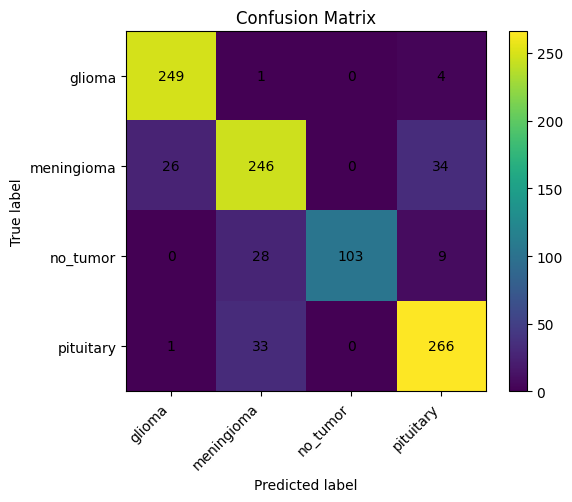

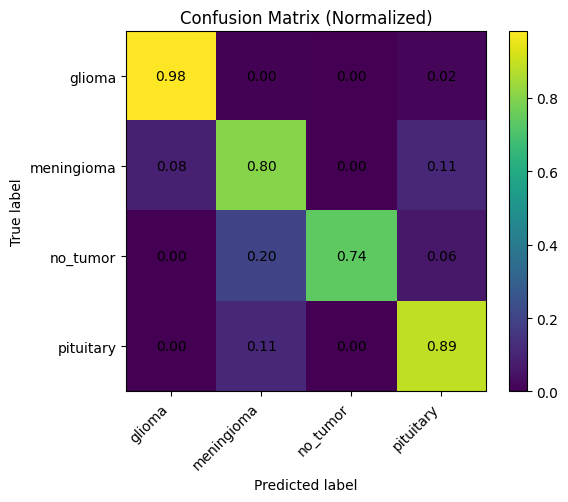

In [37]:
# === CONFUSION MATRIX ===

if TEST_DIR and os.path.isdir(TEST_DIR):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
    plot_confusion_matrix(cm, CLASS_NAMES, normalize=False, title="Confusion Matrix")
    plot_confusion_matrix(cm, CLASS_NAMES, normalize=True, title="Confusion Matrix (Normalized)")
else:
    print("Skip confusion matrix (no TEST_DIR eval).")

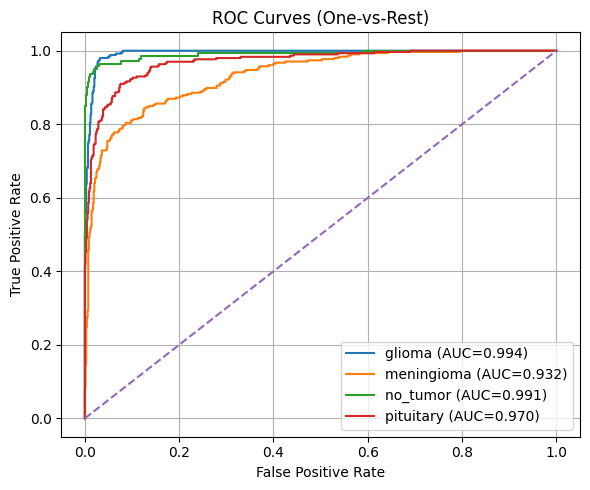

In [38]:
# === ROC CURVE for EACH CLASS ===
if TEST_DIR and os.path.isdir(TEST_DIR):
    y_true_bin = label_binarize(y_true, classes=list(range(len(CLASS_NAMES))))
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(len(CLASS_NAMES)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6,5))
    for i in range(len(CLASS_NAMES)):
        plt.plot(fpr[i], tpr[i], label=f'{CLASS_NAMES[i]} (AUC={roc_auc[i]:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skip ROC (no TEST_DIR eval).")

### 7. Grad-CAM (Model Interpretability) + Ground Truth Mask Overlay

In [39]:
# === INITIATE MODEL ===
dummy_input = tf.zeros((1, 224, 224, 3))
_ = model(dummy_input)
print("Model initialized successfully")

Model initialized successfully


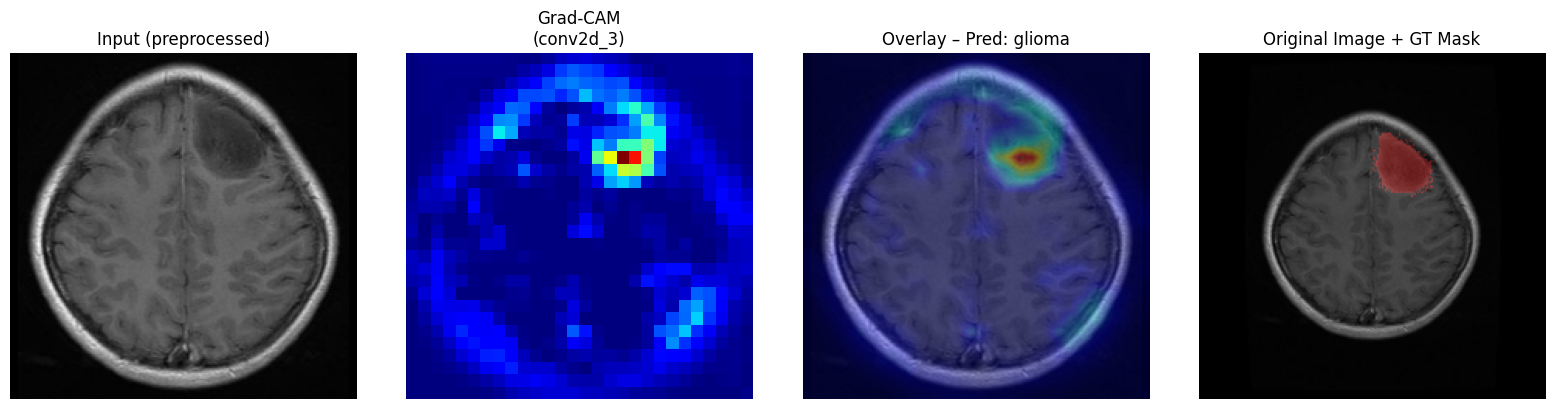


Predicted probabilities:
  glioma      : 1.0000


  meningioma  : 0.0000


  no_tumor    : 0.0000


  pituitary   : 0.0000




In [40]:
# === PREDICT AND VISUALIZE USING GRAD-CAM ===

input_image_path = "/content/brisc2025/segmentation_task/test/images/brisc2025_test_00006_gl_ax_t1.jpg"
mask_path = "/content/brisc2025/segmentation_task/test/masks/brisc2025_test_00006_gl_ax_t1.png"
run_gradcam_demo(input_image_path, mask_path)

Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00001_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00001_gl_ax_t1.png




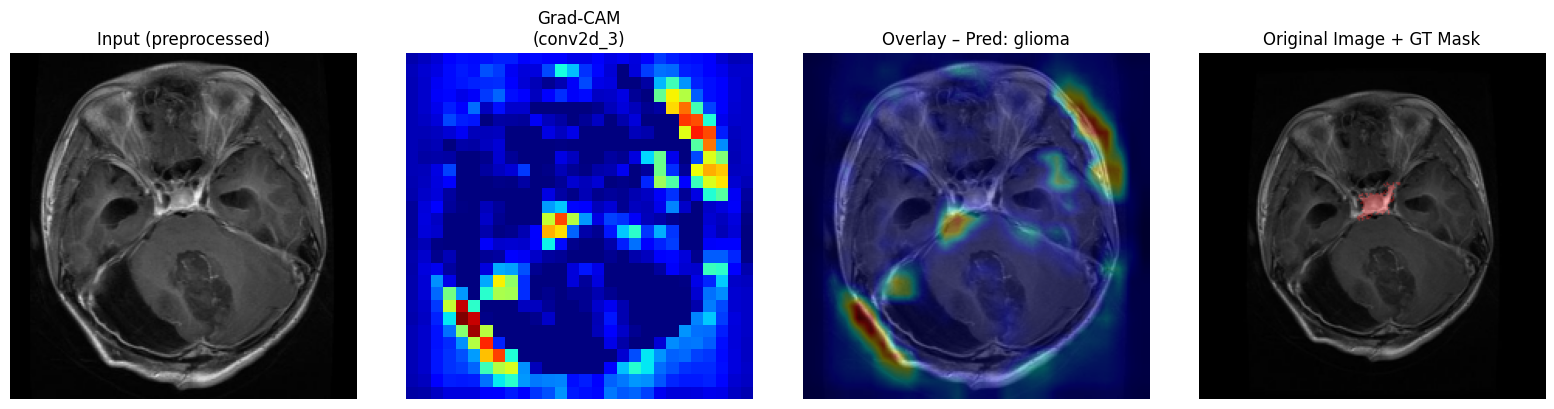


Predicted probabilities:
  glioma      : 0.9994


  meningioma  : 0.0000


  no_tumor    : 0.0001


  pituitary   : 0.0006


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00002_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00002_gl_ax_t1.png




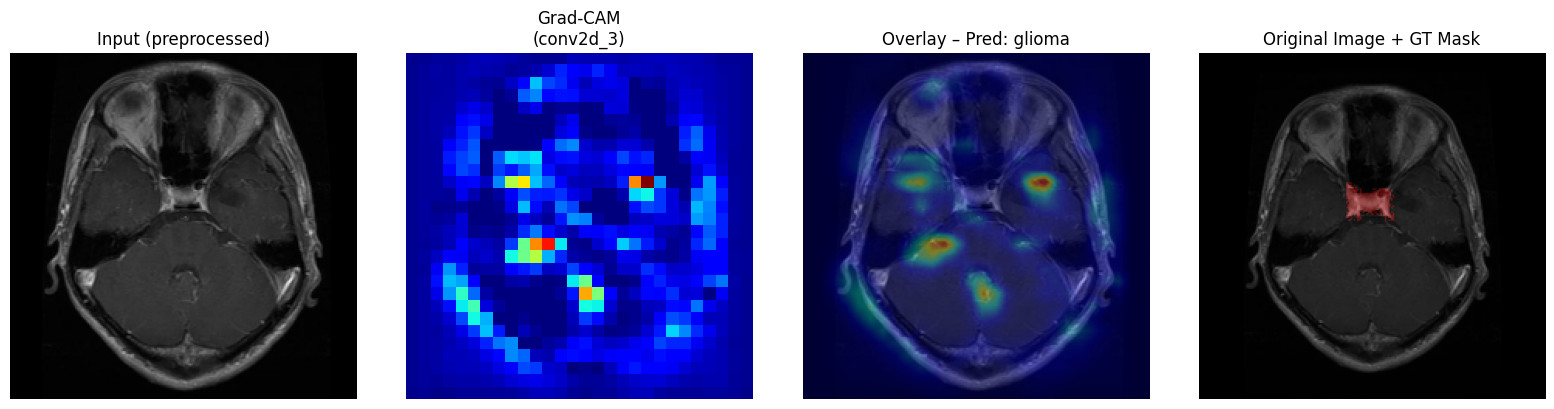


Predicted probabilities:
  glioma      : 1.0000


  meningioma  : 0.0000


  no_tumor    : 0.0000


  pituitary   : 0.0000


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00003_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00003_gl_ax_t1.png




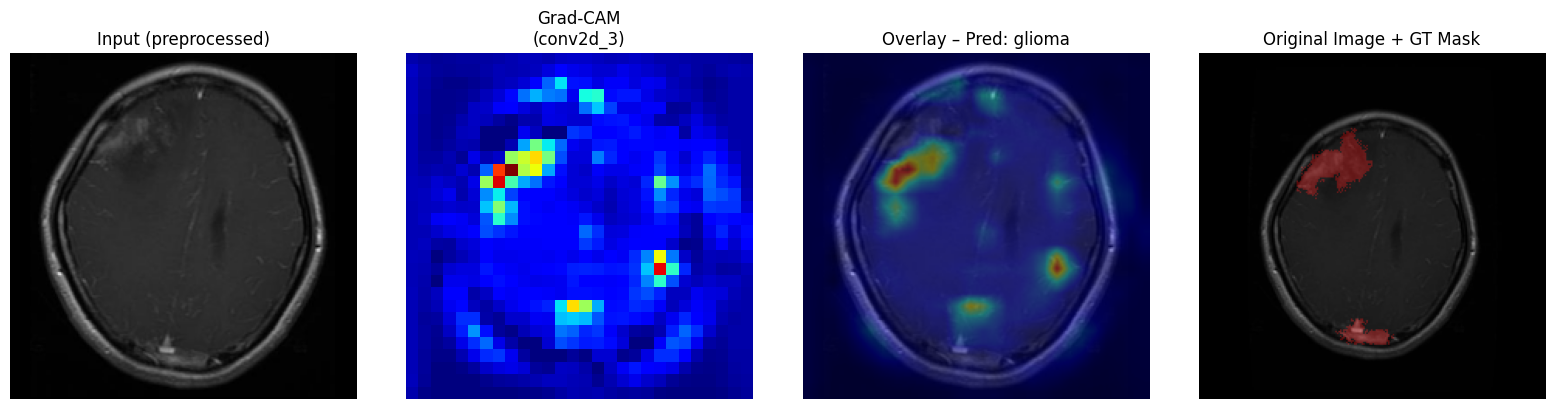


Predicted probabilities:
  glioma      : 1.0000


  meningioma  : 0.0000


  no_tumor    : 0.0000


  pituitary   : 0.0000


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00004_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00004_gl_ax_t1.png




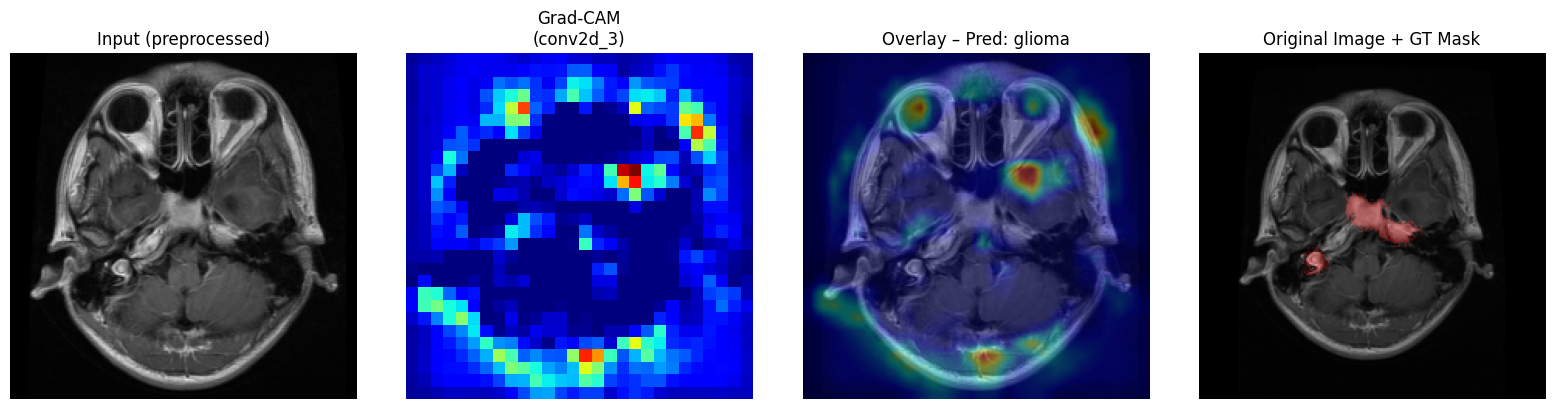


Predicted probabilities:
  glioma      : 0.9985


  meningioma  : 0.0005


  no_tumor    : 0.0000


  pituitary   : 0.0010


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00005_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00005_gl_ax_t1.png




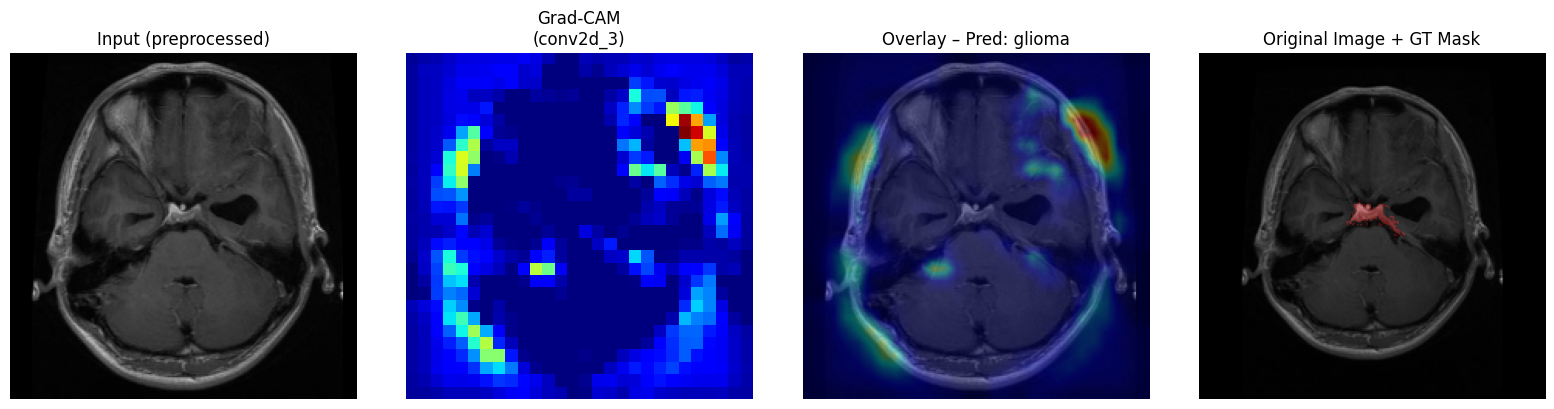


Predicted probabilities:
  glioma      : 0.9994


  meningioma  : 0.0000


  no_tumor    : 0.0000


  pituitary   : 0.0006


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00006_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00006_gl_ax_t1.png




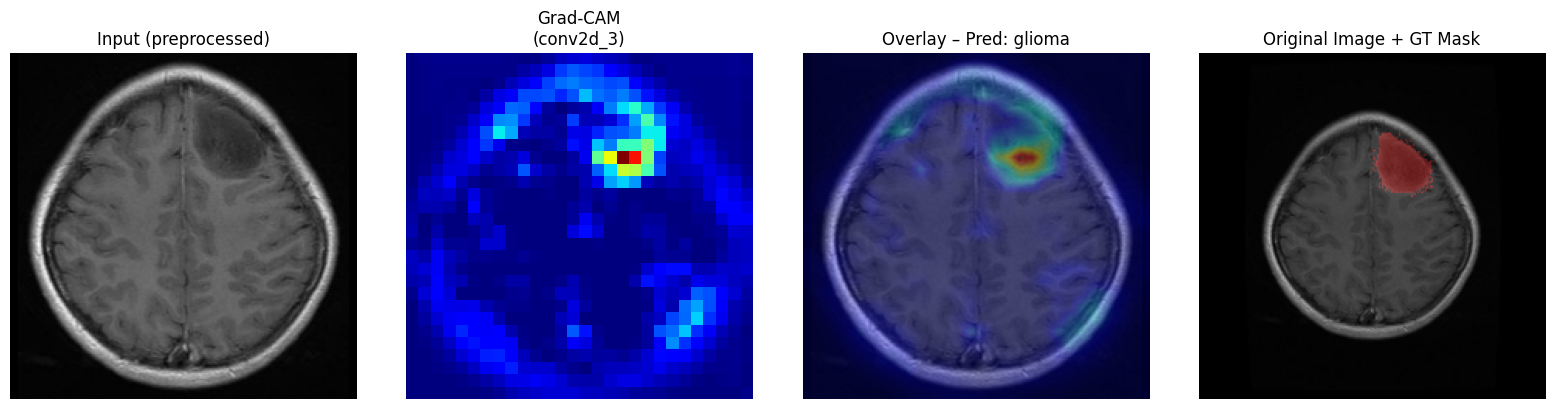


Predicted probabilities:
  glioma      : 1.0000


  meningioma  : 0.0000


  no_tumor    : 0.0000


  pituitary   : 0.0000


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00007_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00007_gl_ax_t1.png




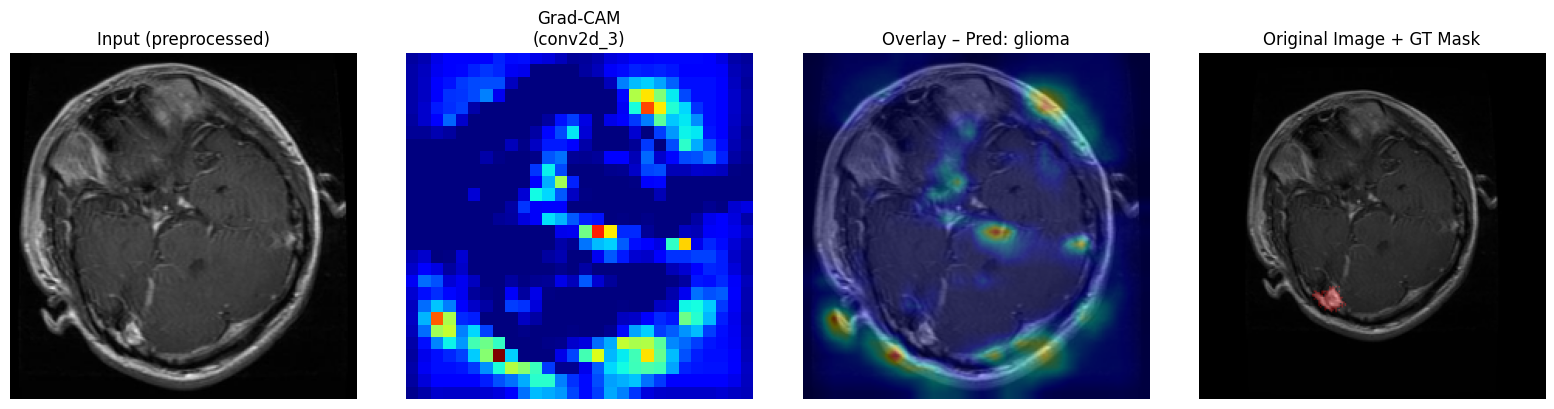


Predicted probabilities:
  glioma      : 0.9694


  meningioma  : 0.0014


  no_tumor    : 0.0000


  pituitary   : 0.0291


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00008_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00008_gl_ax_t1.png




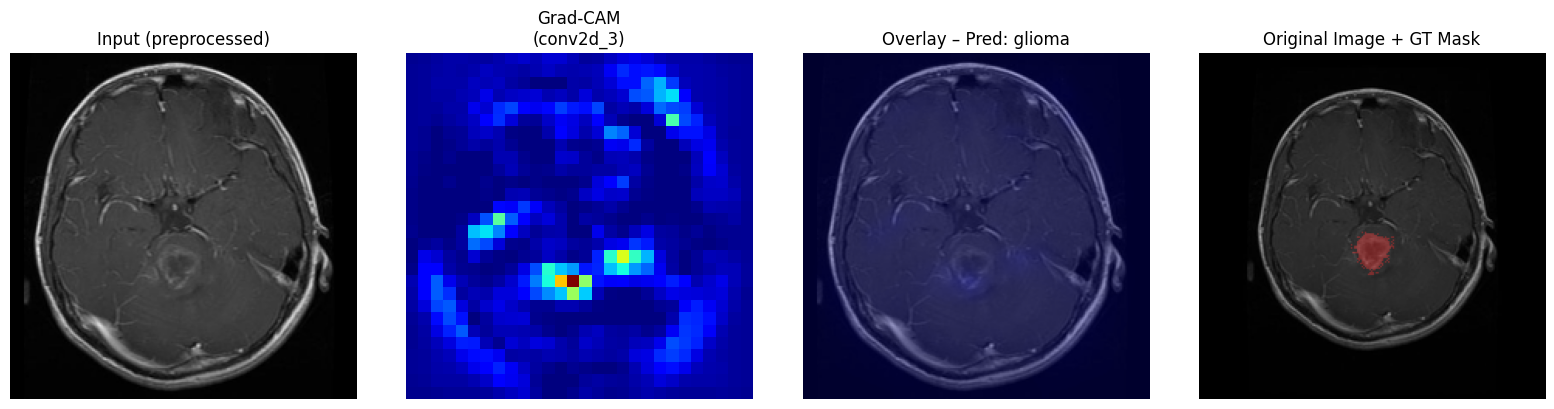


Predicted probabilities:
  glioma      : 1.0000


  meningioma  : 0.0000


  no_tumor    : 0.0000


  pituitary   : 0.0000


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00009_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00009_gl_ax_t1.png




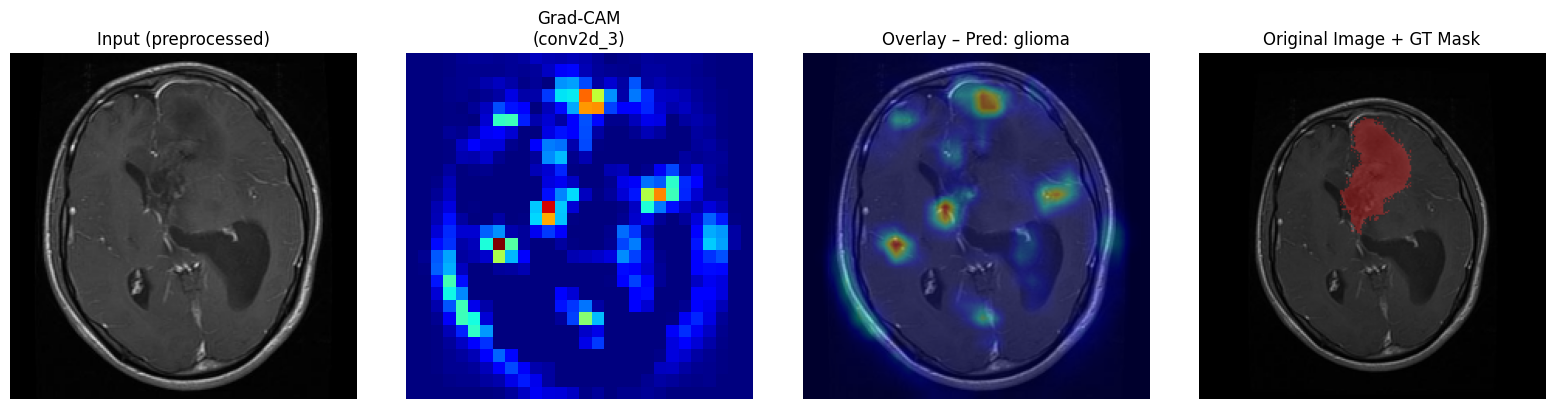


Predicted probabilities:
  glioma      : 1.0000


  meningioma  : 0.0000


  no_tumor    : 0.0000


  pituitary   : 0.0000


Input: /content/brisc2025/segmentation_task/test/images/brisc2025_test_00010_gl_ax_t1.jpg
Mask : /content/brisc2025/segmentation_task/test/masks/brisc2025_test_00010_gl_ax_t1.png




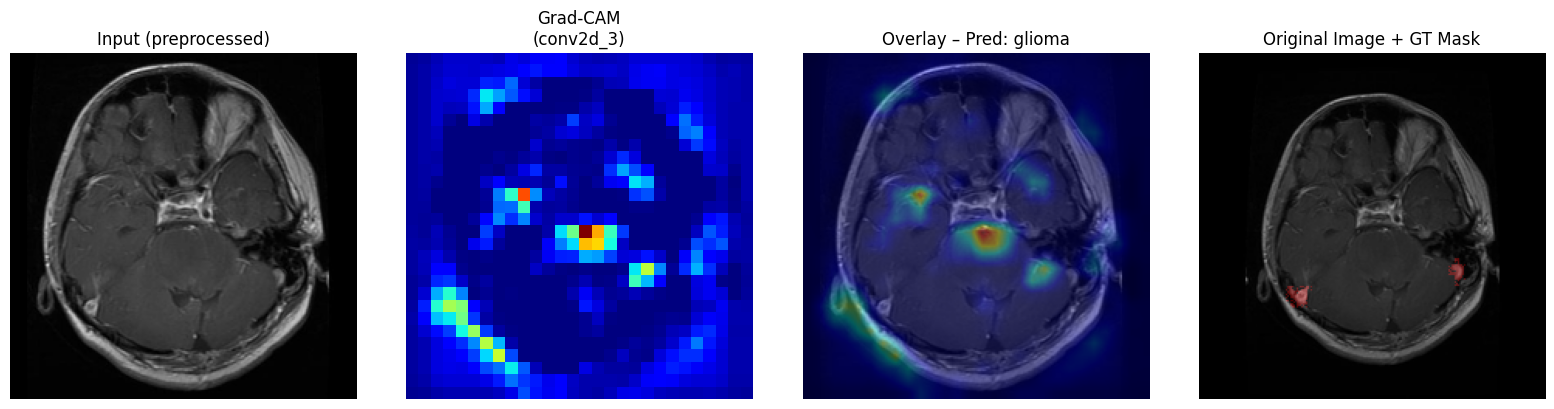


Predicted probabilities:
  glioma      : 0.9995


  meningioma  : 0.0000


  no_tumor    : 0.0000


  pituitary   : 0.0005




In [41]:
# === BATCH PREDICT AND VISUALIZE USING GRAD-CAM ===

images_dir = "/content/brisc2025/segmentation_task/test/images"
masks_dir  = "/content/brisc2025/segmentation_task/test/masks"

run_batch_gradcam_demo(images_dir, masks_dir, n_samples=10)

Kesimpulan kinerja model CNN sederhana : Berdasarkan hasil pengujian pada images_dir dengan 10 n_sample, heat map prediksi banyak yang berbeda dengan groundtruth mask, model lebih banyak fokus pada area tepi kontur dimana disitu terdapat perbedaan nilai pixel yang sangat signifikan. Namun secara gegneral model dapat mengklasifikasikan dengan nilai akurasi 86.40% pada folder test yang ada di sumber dataset berbeda.

In [42]:
drive.mount('/content/drive')
!pipreqs "/content/drive/MyDrive/dico" --scan-notebooks

Mounted at /content/drive


In [43]:
!pipreqs "/content/drive/MyDrive/dico" --scan-notebooks --force

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/dico/requirements.txt
